In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install seaborn

In [ ]:
! pip install shap

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [ ]:
df = pd.read_csv("/content/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [ ]:
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (50000, 14)

Missing Values:
 num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


Overall booking completion rate: 14.96%


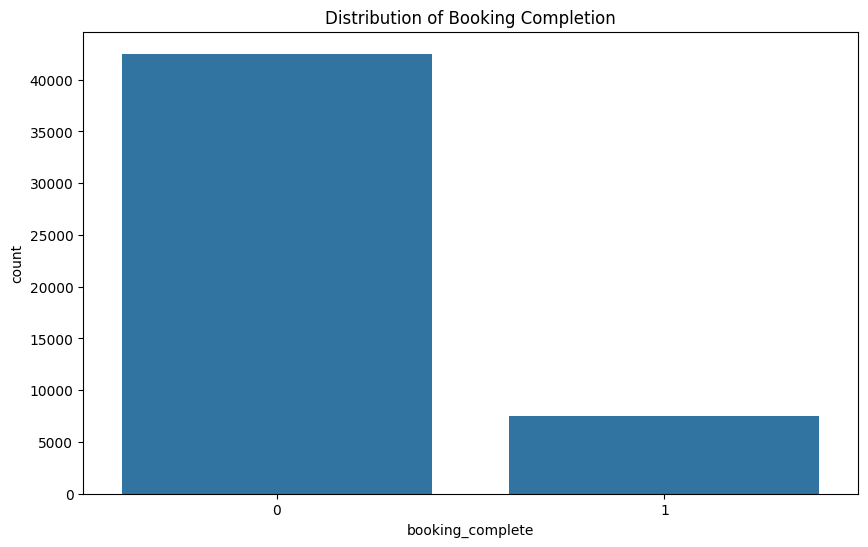

In [37]:
# Booking completion rate analysis
completion_rate = df['booking_complete'].mean() * 100
print(f"Overall booking completion rate: {completion_rate:.2f}%")

# Visualize booking completion distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='booking_complete')
plt.title('Distribution of Booking Completion')
plt.show()

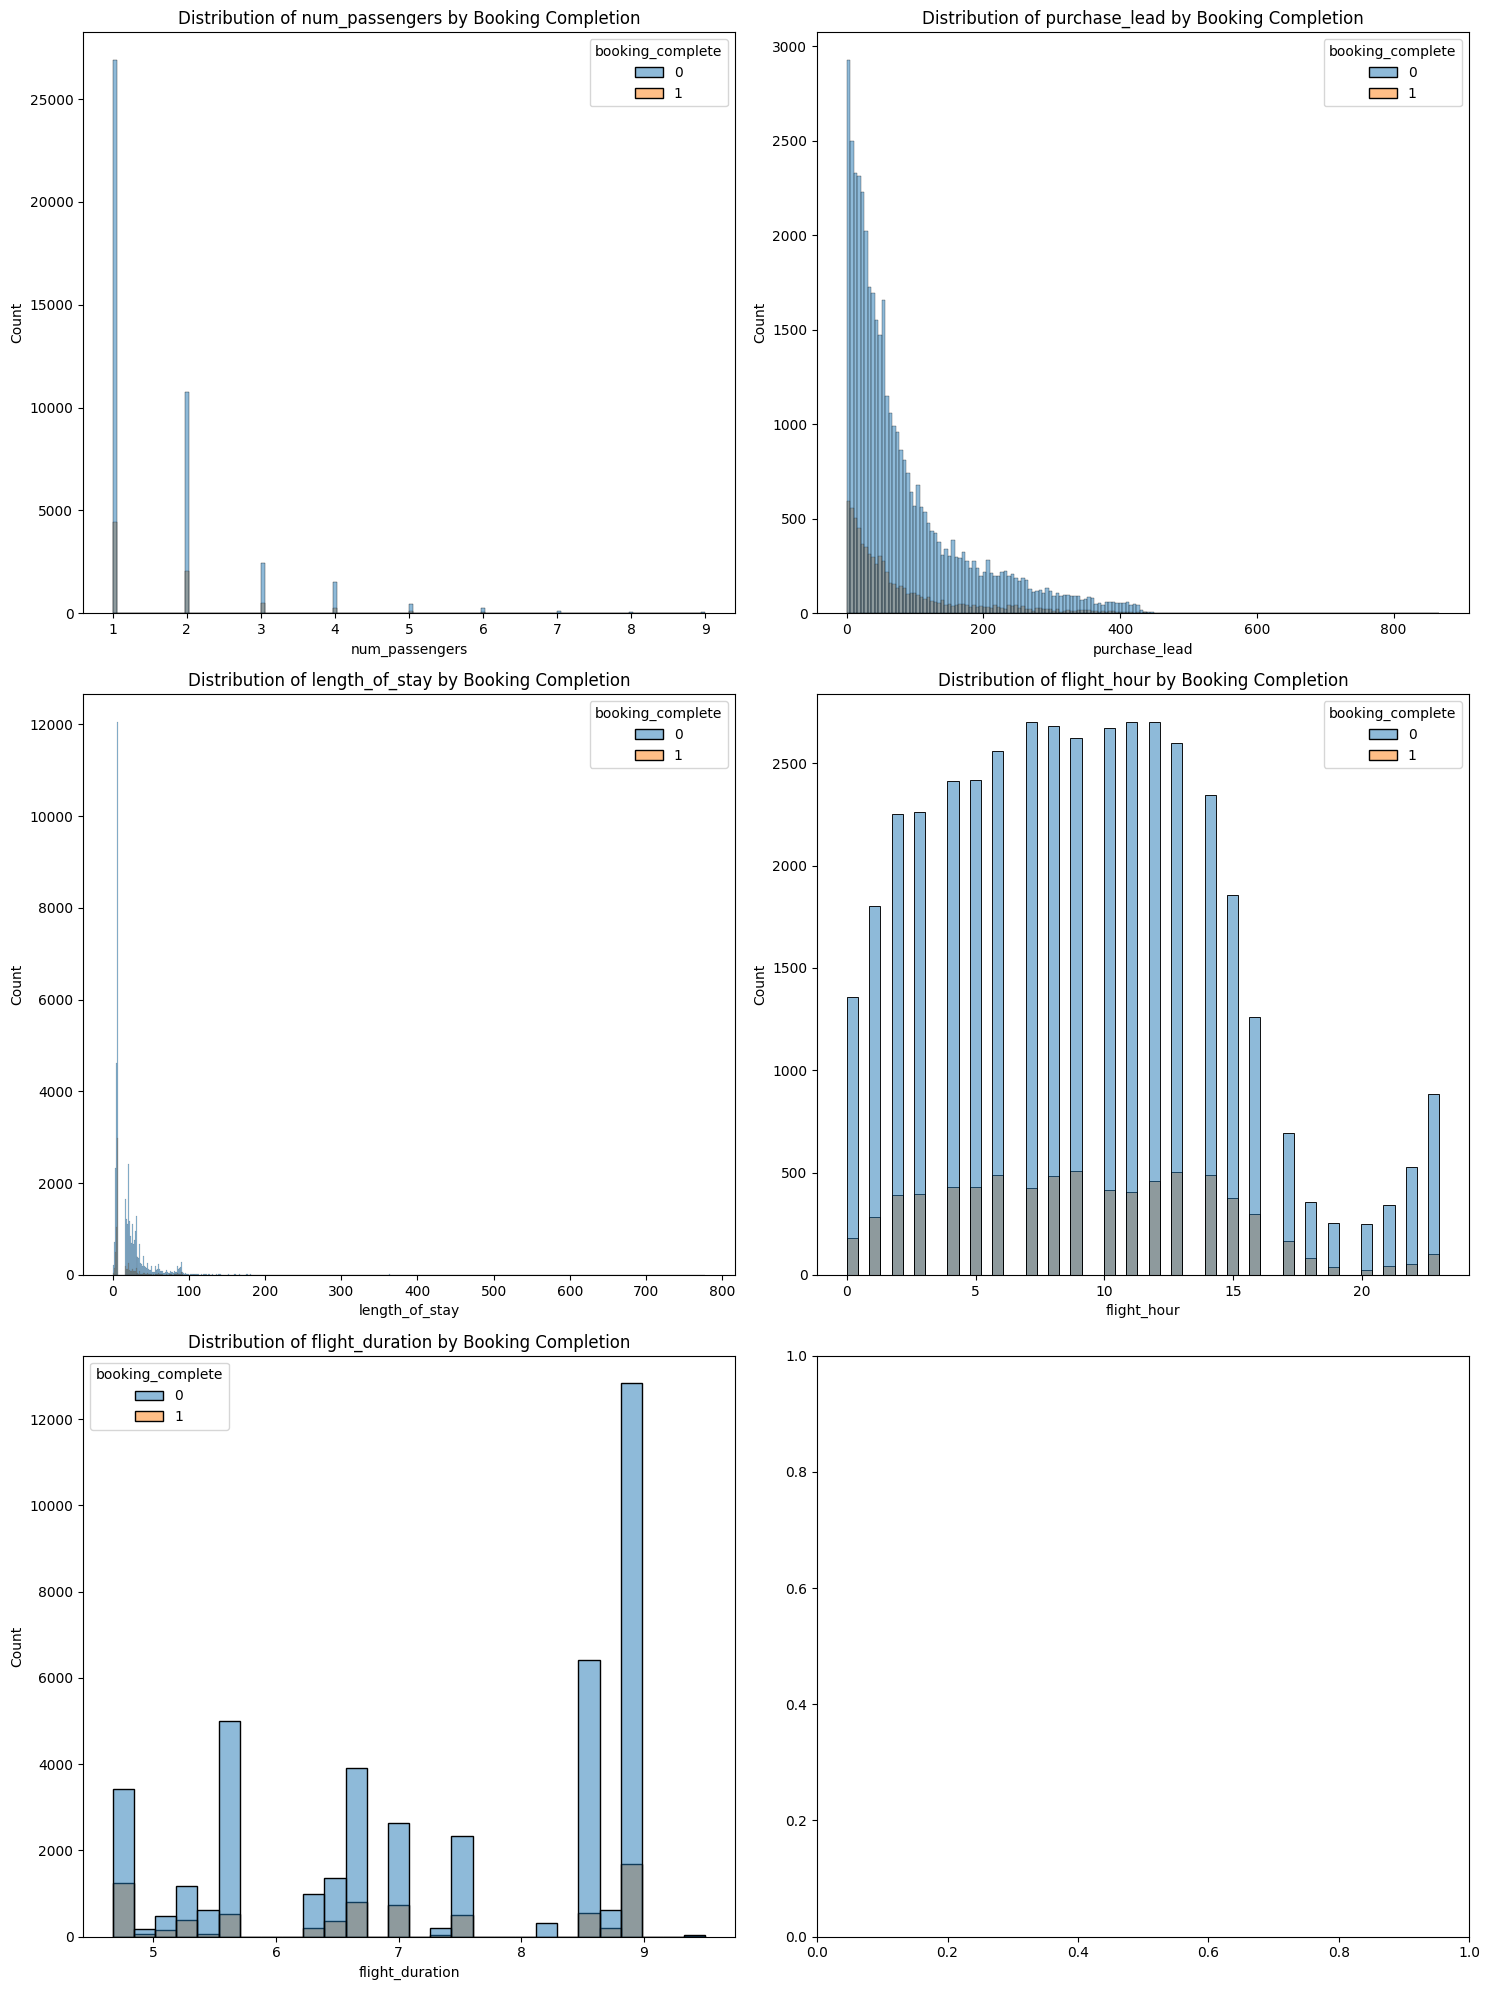

In [38]:
# Analyze numerical features distribution
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay',
                 'flight_hour', 'flight_duration']

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    # Distribution plot
    sns.histplot(data=df, x=col, hue='booking_complete',
                multiple="layer", ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col} by Booking Completion')

plt.tight_layout()
plt.show()

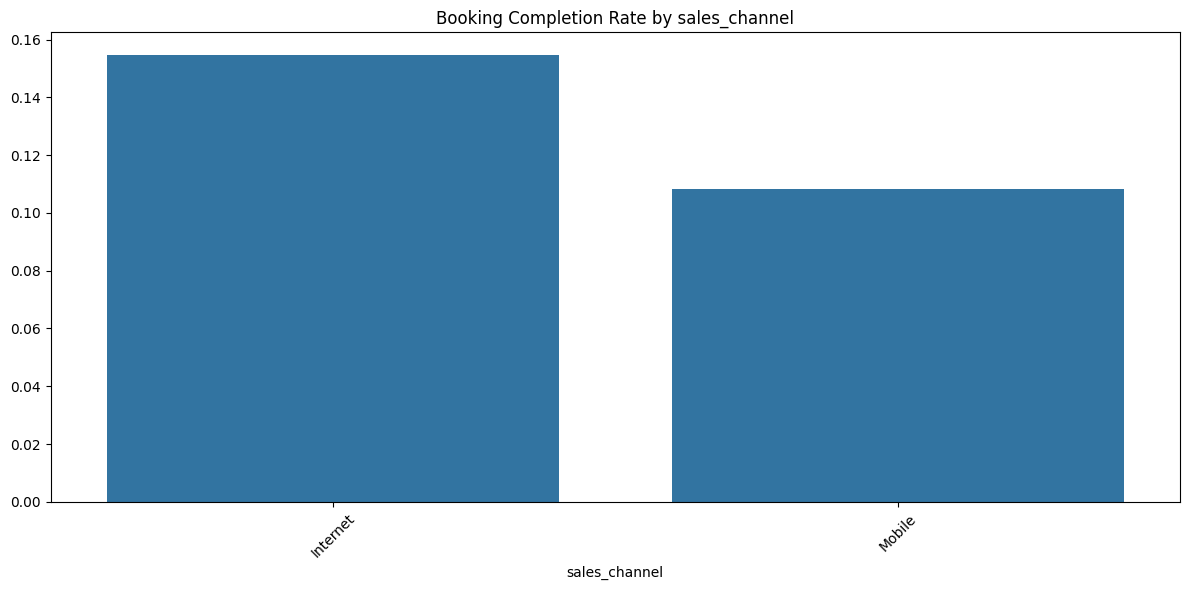


Value counts for sales_channel:
sales_channel
Internet    44382
Mobile       5618
Name: count, dtype: int64

Completion rates for sales_channel:
sales_channel
Internet    0.154770
Mobile      0.108402
Name: booking_complete, dtype: float64
--------------------------------------------------


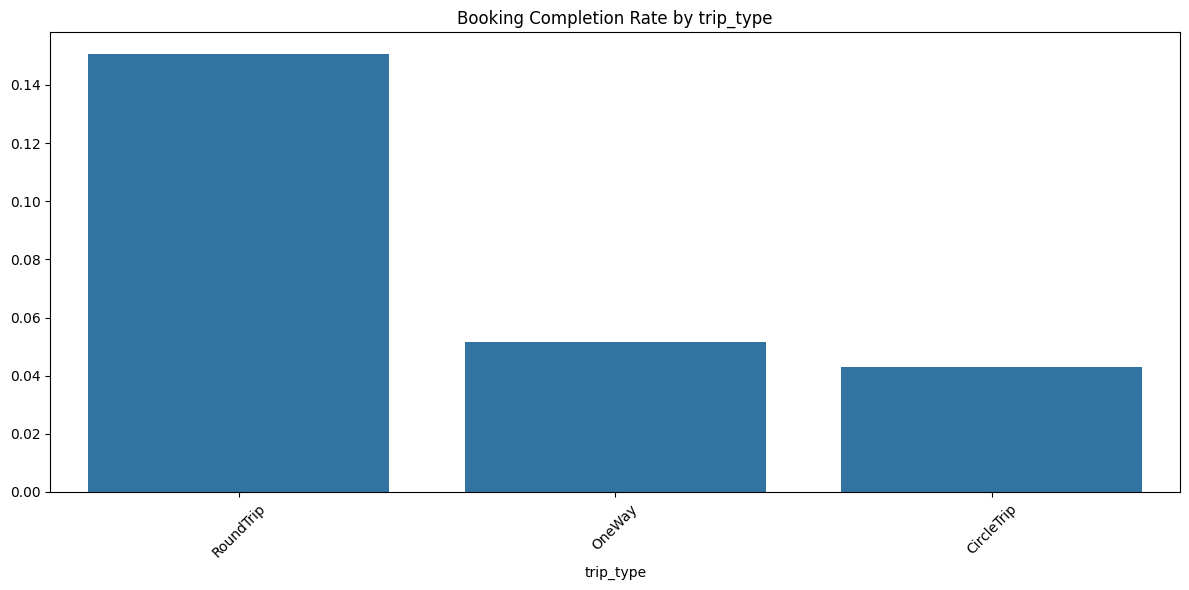


Value counts for trip_type:
trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64

Completion rates for trip_type:
trip_type
RoundTrip     0.150575
OneWay        0.051680
CircleTrip    0.043103
Name: booking_complete, dtype: float64
--------------------------------------------------


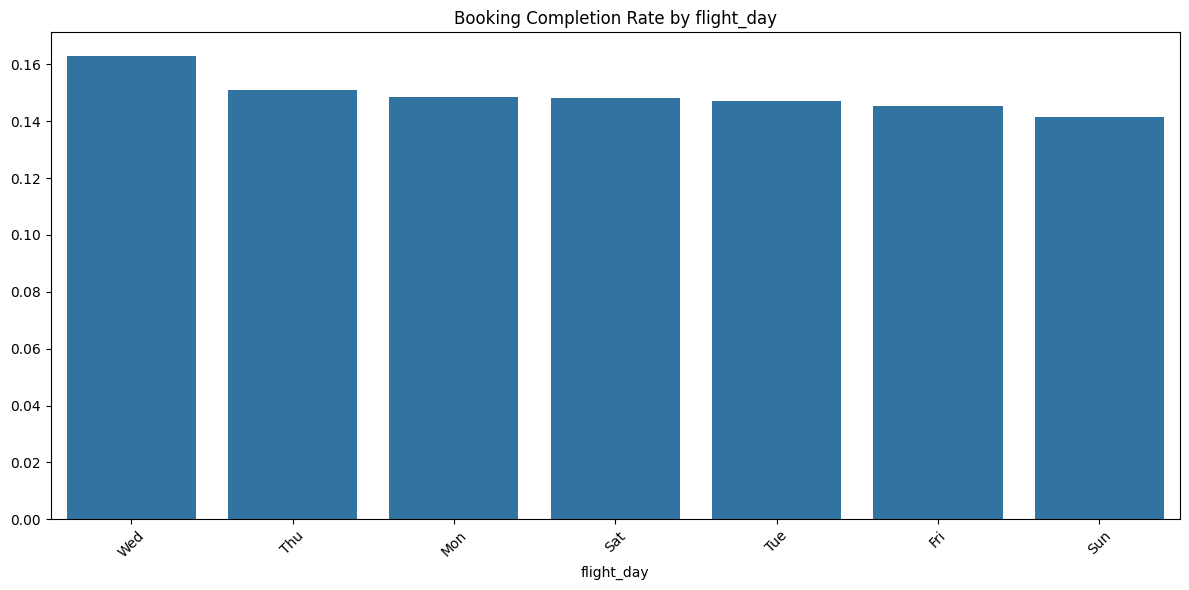


Value counts for flight_day:
flight_day
Mon    8102
Wed    7674
Tue    7673
Thu    7424
Fri    6761
Sun    6554
Sat    5812
Name: count, dtype: int64

Completion rates for flight_day:
flight_day
Wed    0.163148
Thu    0.151131
Mon    0.148605
Sat    0.148142
Tue    0.147139
Fri    0.145393
Sun    0.141440
Name: booking_complete, dtype: float64
--------------------------------------------------


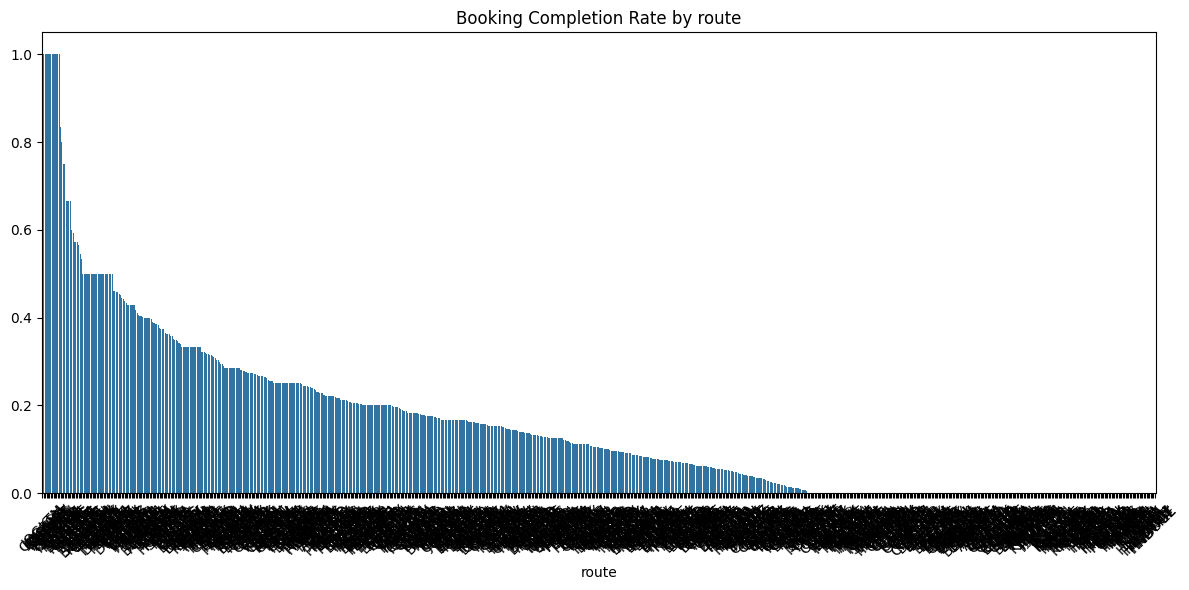


Value counts for route:
route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: count, Length: 799, dtype: int64

Completion rates for route:
route
CKGSGN    1.0
JOGKTM    1.0
KOSSYD    1.0
CXRMEL    1.0
KTMURT    1.0
         ... 
HNDTRZ    0.0
AKLHGH    0.0
HNDOOL    0.0
HNDMLE    0.0
URTXIY    0.0
Name: booking_complete, Length: 799, dtype: float64
--------------------------------------------------


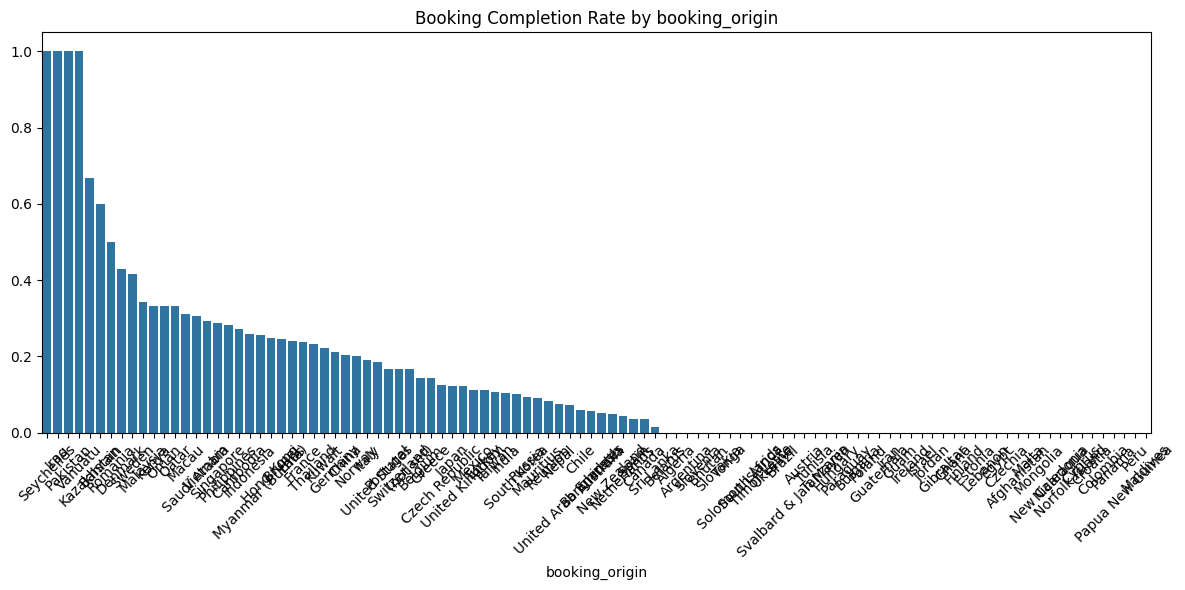


Value counts for booking_origin:
booking_origin
Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: count, Length: 104, dtype: int64

Completion rates for booking_origin:
booking_origin
Seychelles          1.000000
Iraq                1.000000
Pakistan            1.000000
Vanuatu             1.000000
Kazakhstan          0.666667
                      ...   
Colombia            0.000000
Panama              0.000000
Papua New Guinea    0.000000
Peru                0.000000
Maldives            0.000000
Name: booking_complete, Length: 104, dtype: float64
--------------------------------------------------


In [42]:
# Analyze categorical features
categorical_cols = ['sales_channel', 'trip_type', 'flight_day',
                   'route', 'booking_origin']

# Create completion rate by categorical features
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    completion_rates = df.groupby(col)['booking_complete'].mean().sort_values(ascending=False)

    sns.barplot(x=completion_rates.index, y=completion_rates.values)
    plt.title(f'Booking Completion Rate by {col}')
    plt.xticks(rotation=45)
    plt.savefig(f'Booking Completion Rate by {col}', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    # Print value counts and completion rates
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())
    print(f"\nCompletion rates for {col}:")
    print(completion_rates)
    print("-"*50)

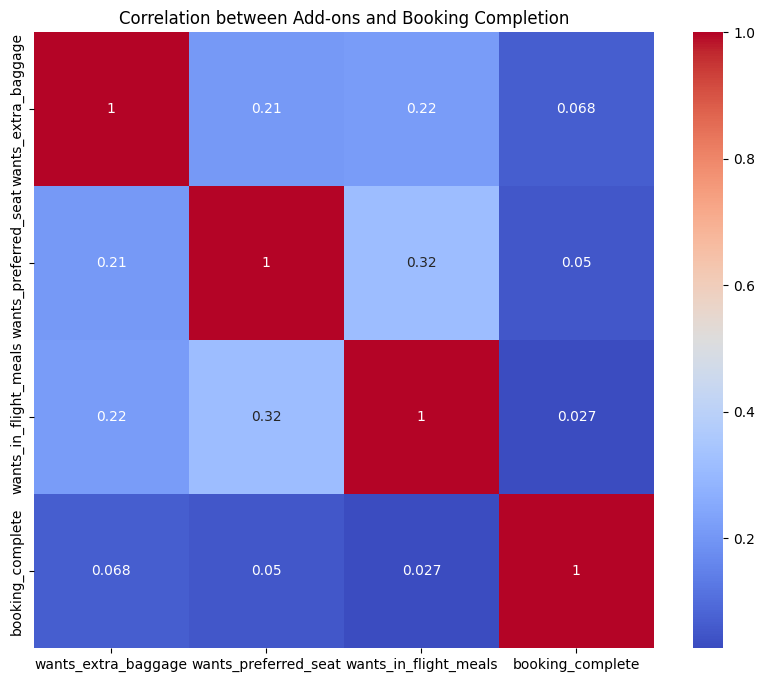

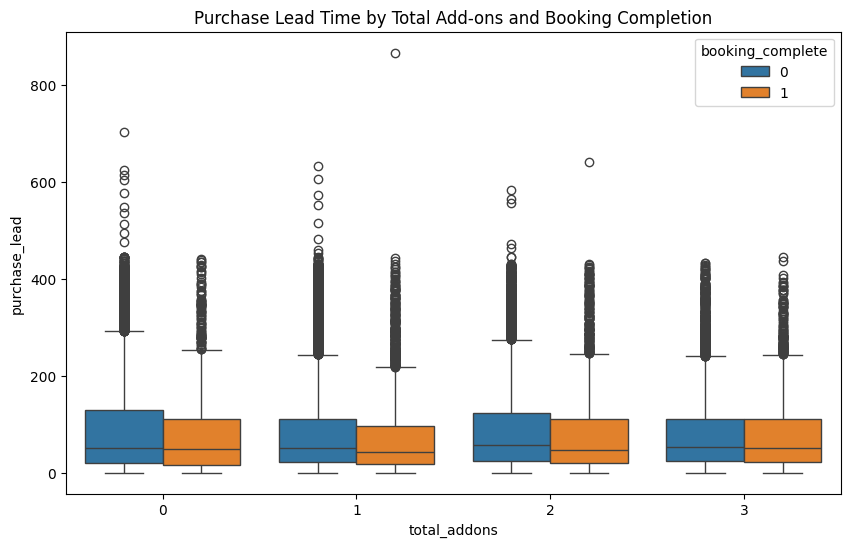

In [40]:
# Analyze add-on preferences
addon_cols = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

# Create correlation matrix for add-ons
plt.figure(figsize=(10, 8))
sns.heatmap(df[addon_cols + ['booking_complete']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Correlation between Add-ons and Booking Completion')
plt.show()

# Analyze combined add-on effect
df['total_addons'] = df[addon_cols].sum(axis=1)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='total_addons', y='purchase_lead', hue='booking_complete')
plt.title('Purchase Lead Time by Total Add-ons and Booking Completion')
plt.show()

In [ ]:
# Time-based analysis
# Create hour groups
df['hour_group'] = pd.cut(df['flight_hour'],
                         bins=[0, 6, 12, 18, 24],
                         labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Analyze booking patterns by time
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='hour_group', y='booking_complete')
plt.title('Booking Completion Rate by Time of Day')
plt.show()

# Analyze day of week patterns
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='flight_day', y='booking_complete')
plt.title('Booking Completion Rate by Day of Week')
plt.show()

In [ ]:
# Feature Engineering

In [ ]:
# Create a copy to avoid modifying the original dataframe
df_processed = df.copy()

In [ ]:
df_processed["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [ ]:
# Convert flight_day to numeric
day_mapping = {
    "Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4,
    "Fri": 5, "Sat": 6, "Sun": 7
}
df_processed['flight_day'] = df_processed['flight_day'].map(day_mapping)


In [ ]:
df_processed["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [ ]:
 # Create new features
# Time-based features
df_processed['is_weekend'] = df_processed['flight_day'].isin([6, 7]).astype(int)
df_processed['is_business_hours'] = ((df_processed['flight_hour'] >= 8) &
                                       (df_processed['flight_hour'] <= 18)).astype(int)


In [ ]:
 # Booking behavior features
df_processed['total_add_ons'] = (df_processed['wants_extra_baggage'] +
                                df_processed['wants_preferred_seat'] +
                                df_processed['wants_in_flight_meals'])


In [ ]:
# Trip complexity score
df_processed['trip_complexity'] = (df_processed['length_of_stay'] *
                                    df_processed['num_passengers'])

In [ ]:
 # Booking lead time categories
df_processed['lead_time_category'] = pd.cut(df_processed['purchase_lead'],
                                            bins=[0, 7, 30, 90, np.inf],
                                            labels=['last_minute', 'short_term',
                                                    'medium_term', 'long_term'])


In [ ]:
 # Length of stay categories
df_processed['stay_duration_category'] = pd.cut(df_processed['length_of_stay'],
                                                bins=[0, 3, 7, 14, np.inf],
                                                labels=['short', 'week',
                                                        'fortnight', 'extended'])


In [ ]:
# Encode categorical variables
categorical_columns = ['sales_channel', 'trip_type', 'route',
                        'booking_origin', 'lead_time_category',
                        'stay_duration_category']


In [ ]:
for col in categorical_columns:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])

In [ ]:
df_processed.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,is_weekend,is_business_hours,total_add_ons,trip_complexity,lead_time_category,stay_duration_category
0,2,0,2,262,19,7,6,0,61,1,0,0,5.52,0,1,0,1,38,1,0
1,1,0,2,112,20,3,6,0,61,0,0,0,5.52,0,1,0,0,20,1,0
2,2,0,2,243,22,17,3,0,36,1,1,0,5.52,0,0,1,2,44,1,0
3,1,0,2,96,31,4,6,0,61,0,0,1,5.52,0,1,0,1,31,1,0
4,2,0,2,68,22,15,3,0,36,1,0,1,5.52,0,0,1,2,44,2,0


In [ ]:
# Model Training and Evaluation

In [ ]:
# Separate features and target
features = df_processed.drop(['booking_complete'], axis=1)
target = df_processed['booking_complete']

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

In [ ]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5,
                            scoring='roc_auc')
print("\nCross-validation ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC: {:.3f} (+/- {:.3f})".format(
    cv_scores.mean(), cv_scores.std() * 2))


Cross-validation ROC-AUC scores: [0.73671542 0.75329794 0.73586661 0.74071838 0.7780807 ]
Mean CV ROC-AUC: 0.749 (+/- 0.032)


In [ ]:
# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)

In [ ]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.57      0.10      0.16      1480

    accuracy                           0.86     10000
   macro avg       0.72      0.54      0.54     10000
weighted avg       0.82      0.86      0.81     10000



In [ ]:
# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
print("\nTest Set ROC-AUC Score:", roc_auc)



Test Set ROC-AUC Score: 0.7621292903819312


In [ ]:
# Feature Importance Visualization

In [ ]:
# Get feature importance
importance = rf_model.feature_importances_

In [ ]:
# After creating your features DataFrame
feature_names = features.columns.tolist()

In [ ]:
# Create DataFrame for visualization
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})

In [ ]:
# Sort by importance
feature_importance = feature_importance.sort_values(
    'importance', ascending=False
)

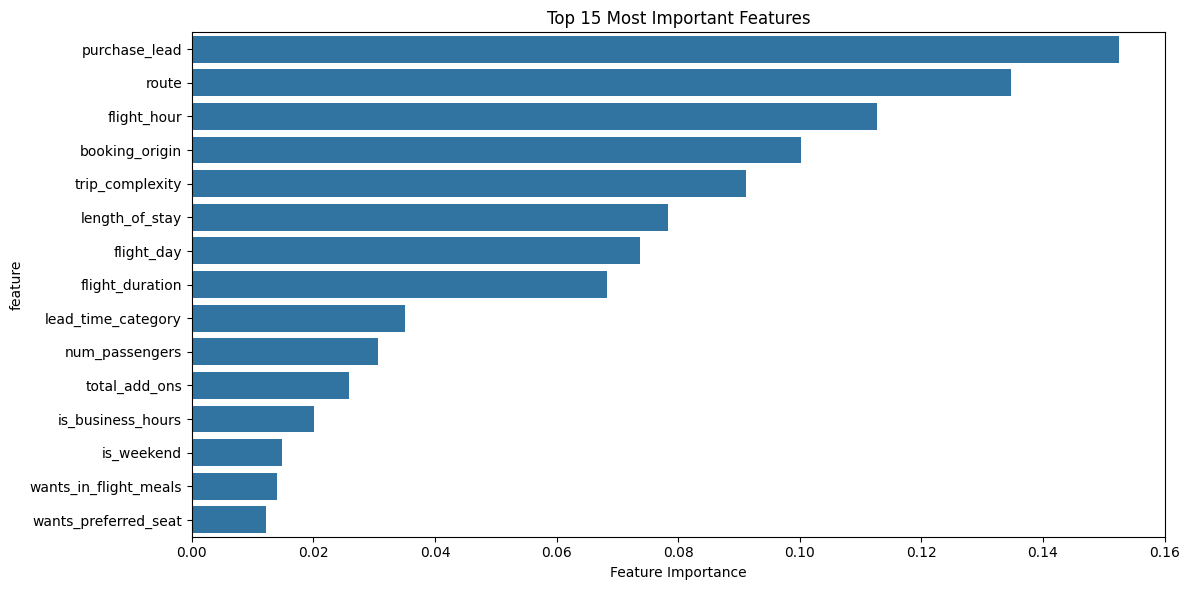

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.savefig('features.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [ ]:
# SHAP Values Analysis

In [ ]:
# Calculate SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)


TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1200x800 with 0 Axes>

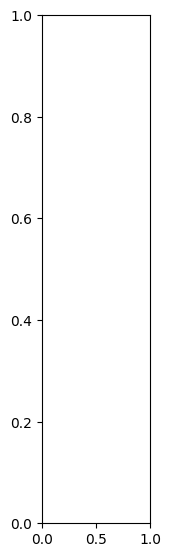

In [41]:


# Use a smaller sample for SHAP analysis to avoid memory issues
sample_size = 1000
sample_indices = np.random.choice(X_test_scaled.shape[0], sample_size, replace=False)
X_test_sample = X_test_scaled[sample_indices]

# Calculate SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_sample)

# Create summary plot for binary classification
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values[1] if isinstance(shap_values, list) else shap_values,
    X_test_sample,
    feature_names=feature_names,
    show=False
)
plt.title('SHAP Values Impact on Booking Completion')
plt.tight_layout()
plt.show()

In [ ]:
# Create detailed SHAP analysis for top features
# Get feature importance based on SHAP values
shap_importance = np.abs(shap_values[1]).mean(0) if isinstance(shap_values, list) else np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': shap_importance
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 5 feature dependencies
top_features = feature_importance['feature'].head().values
for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        feature,
        shap_values[1] if isinstance(shap_values, list) else shap_values,
        X_test_sample,
        feature_names=feature_names,
        show=False
    )
    plt.title(f'SHAP Dependence Plot for {feature}')
    plt.tight_layout()
    plt.show()

In [ ]:
# Create summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values[1], X_test_scaled,
                    feature_names=feature_names, show=False)
plt.title('SHAP Values Impact on Booking Completion')
plt.savefig('summary.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1200x800 with 0 Axes>